## Correlation between mainshocks and surface mass loading

#### - declustered with Mizrahi's ETAS code

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd

# file containing functions:
import loadquakes

In [2]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [3]:
rates = ds['lwe_thickness'].diff('time')
rates.name = 'loading_rate'
ds['loading_rate'] = rates

In [4]:
type(ds)

xarray.core.dataset.Dataset

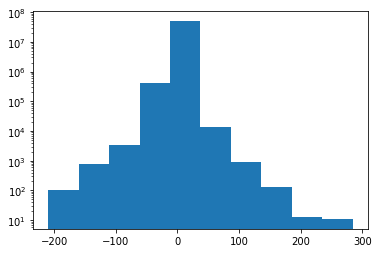

In [5]:
# Loading rate during all time periods

fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.hist(ds['loading_rate'].data.flatten())
plt.yscale('log')

In [6]:
mainshock = catalog[catalog['P_triggered']<.9]
mainshock

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background
49,53,2.6675,-59.5879,2021-01-31 19:05:14.367,5.5,POINT (2.6675 -59.5879),8.774521e-11,0.081552,0.918448
50,54,-13.9672,121.8641,2021-01-29 19:47:55.783,5.7,POINT (-13.9672 121.8641),8.774521e-11,0.634690,0.365310
54,58,18.2516,-64.0708,2021-01-24 23:21:41.140,5.4,POINT (18.2516 -64.07080000000001),8.774521e-11,0.829974,0.170026
73,77,-37.1225,-17.2548,2021-01-15 10:45:21.876,5.6,POINT (-37.1225 -17.2548),8.774521e-11,0.871333,0.128667
80,84,51.2811,100.4383,2021-01-11 21:32:59.015,6.7,POINT (51.2811 100.4383),8.774521e-11,0.729328,0.270672
...,...,...,...,...,...,...,...,...,...
9426,9430,84.2530,0.4080,2006-02-14 00:39:49.590,5.4,POINT (84.25299999999999 0.408),8.774521e-11,0.488028,0.511972
9427,9431,-62.2100,-158.1880,2006-02-13 03:23:35.610,5.4,POINT (-62.21 -158.188),8.774521e-11,0.878727,0.121273
9436,9440,66.2968,-142.6856,2006-02-05 08:17:01.373,5.4,POINT (66.2968 -142.6856),8.774521e-11,0.494733,0.505267
9437,9441,1.0930,-90.4600,2006-02-04 09:17:04.090,5.9,POINT (1.093 -90.45999999999999),8.774521e-11,0.700162,0.299838


In [7]:
pd.options.mode.chained_assignment = None

In [8]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data

def get_mass_rate(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["loading_rate"]
    return mass_change.data
  
mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)
mainshock['loading_rate'] = mainshock.apply(lambda row: get_mass_rate(row), axis=1)

In [9]:
mainshock.loading_rate

49      -0.20319548786804997
50        0.8412606154982991
54        0.4186036157226365
73       -0.7553214435727118
80        0.6889384420543379
                ...         
9426    -0.23154228528011256
9427     -3.4268429011605965
9436    -0.26713710369289245
9437      0.7191034405071668
9446      0.7045291303748303
Name: loading_rate, Length: 510, dtype: object

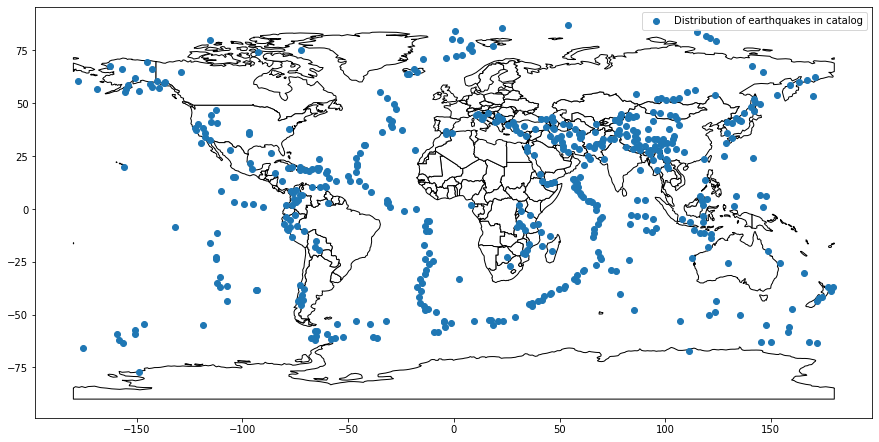

In [10]:
# Distribution of all mainshocks

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(mainshock.longitude, mainshock.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

In [11]:
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/bradlipovsky/notebooks/gia-quakes/loadquakes.py'>

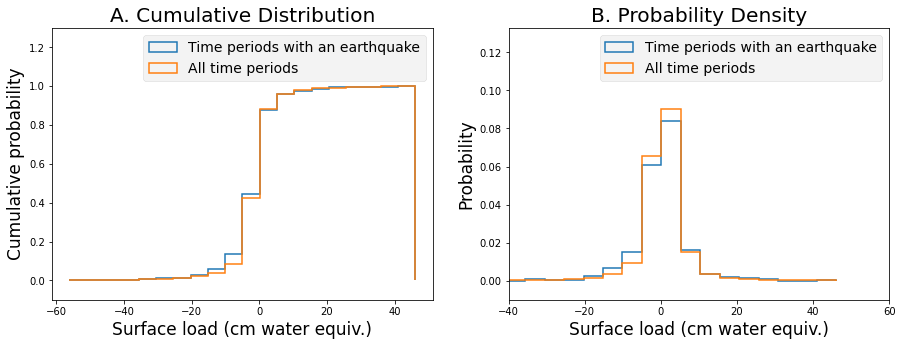

In [12]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('fivethirtyeight')

loadquakes.plot_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(mainshock.dmass), ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

In [13]:
# takes very long time to load:

# loadquakes.calc_stats(np.array(mainshock.dmass),np.array(ds['lwe_thickness'].data.flatten()))

## Using Bayes' Theorem:

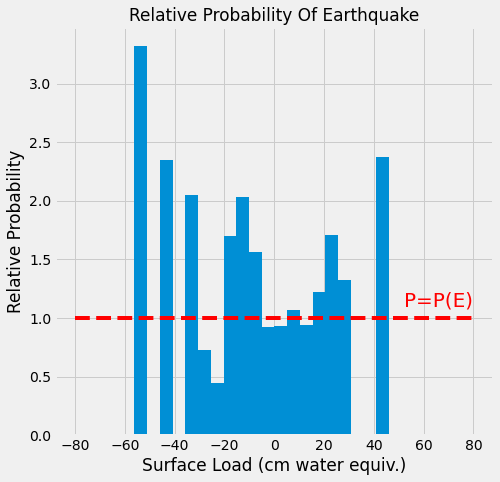

In [14]:
loadquakes.plot_rel_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(mainshock.dmass), ax, 
              "Relative Probability Of Earthquake")

## Mapping earthquakes with high conditional probability

In [15]:
def high_cond_prob(earthquake_only, all_time_periods, bins):
    
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
    
    which_bin = np.digitize(earthquake_only,bins)
    height = LgE/L
    high_cond_prob = height[height > 2]
    
    indices = np.where(np.in1d(height, high_cond_prob))[0]
     
    print("Bin number =")
    print(indices)
    
    print("Surface load = ")
    for i in range(len(indices)):
        print("Between")
        print(bins[indices[i-1]])
        print("and")
        print(bins[indices[i-1]+1])
        
    print("Corresponding bin height = ")
    for i in range(len(indices)):
        print(height[indices[i-1]])

In [16]:
# np.where(height > 2)

In [18]:
conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(mainshock.dmass), np.array(mainshock.dmass))

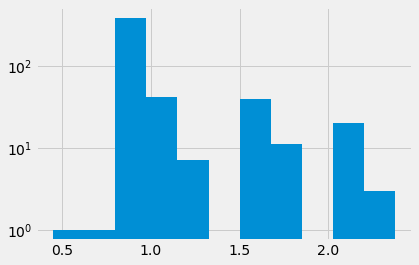

In [35]:
mainshock['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(mainshock['cp']),11)
plt.yscale('log')

In [21]:
mainshock[mainshock.cp > 1.5].sort_values('magnitude')

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background,dmass,loading_rate,cp
3930,3934,4.1909,86.7252,2014-03-27 04:00:15.540,5.4,POINT (4.1909 86.7252),8.774521e-11,0.730205,0.269795,-11.677844038970811,0.1342251588309047,2.034824
2879,2883,29.3985,81.6541,2015-12-18 22:16:56.550,5.4,POINT (29.3985 81.6541),8.774521e-11,0.890007,0.109993,-11.724276700447325,-7.216615138957295,2.034824
4625,4629,31.8280,50.9540,2013-01-12 03:25:04.370,5.4,POINT (31.82800000000001 50.95399999999999),8.774521e-11,0.624569,0.375431,-6.778876826206092,4.38107655575825,1.566601
2408,2412,39.4848,54.5087,2016-10-26 14:15:40.610,5.4,POINT (39.4848 54.5087),8.774521e-11,0.315486,0.684514,-8.088554645091927,-1.0309223419963267,1.566601
8569,8573,6.7050,-72.9460,2007-05-06 04:47:13.680,5.4,POINT (6.705 -72.946),8.774521e-11,0.488851,0.511149,-13.613113423770603,4.062651813030243,2.034824
...,...,...,...,...,...,...,...,...,...,...,...,...
4449,4453,28.4280,51.5930,2013-04-09 11:52:49.920,6.4,POINT (28.428 51.593),8.774521e-11,0.873504,0.126496,-10.123261341462946,-1.1077752113342285,2.034824
5202,5206,51.8420,95.9110,2011-12-27 15:21:56.840,6.6,POINT (51.842 95.911),8.774521e-11,0.444521,0.555479,-5.294499851234284,1.7077793909324948,1.566601
8034,8038,10.6710,-41.8990,2008-02-08 09:38:14.100,6.9,POINT (10.671 -41.899),8.774521e-11,0.503263,0.496737,-5.282399920147915,-0.9493823782966428,1.566601
5303,5307,38.7210,43.5080,2011-10-23 10:41:23.250,7.1,POINT (38.721 43.508),8.774521e-11,0.755150,0.244850,-5.257453518094782,1.4400405276961052,1.566601


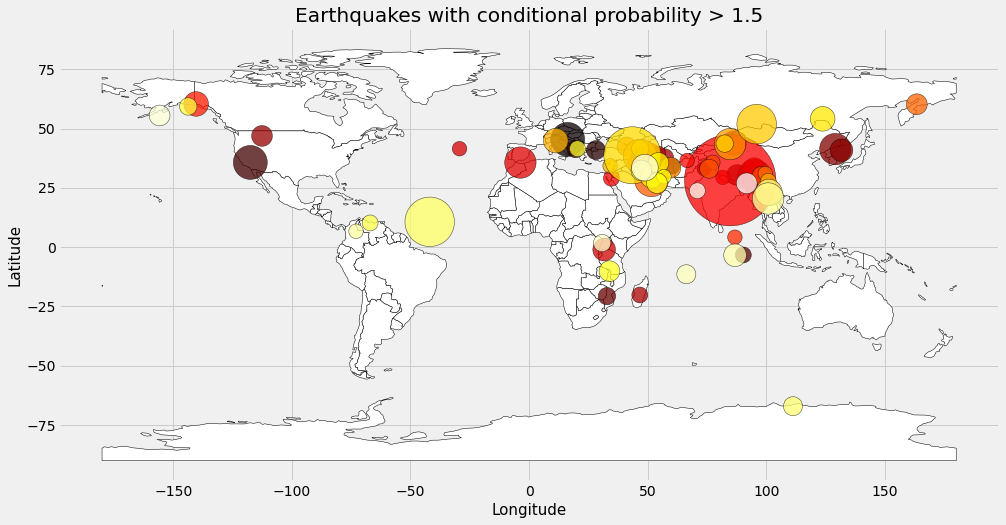

In [52]:
load_bounds = mainshock[mainshock['cp']>1.5]

def probability_map(load_bounds,color,label):

    gdf = gpd.GeoDataFrame(load_bounds,
                           geometry=gpd.points_from_xy(load_bounds.longitude, load_bounds.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))


    pl=gdf.plot(ax=ax, markersize = 1e-5*load_bounds.magnitude**10, 
             c = color/max(color), alpha=0.75, cmap='hot',
                edgecolor='k')
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
#     leg = ax.legend()
    ax.set_title(label)
    plt.show()

probability_map(load_bounds,load_bounds.cp,
                'Earthquakes with conditional probability > 1.5')

In [54]:
# high_cond_prob(np.array(mainshock.dmass),
#                np.array(ds['lwe_thickness'].data.flatten()),bins)

In [ ]:
# importlib.reload(loadquakes)

In [56]:
# loadquakes.plot_same_map(mainshock['dmass'],mainshock['dmass'],
#              mainshock[(44 < mainshock['dmass']) & (mainshock['dmass'] < 48)],
#              mainshock[(-60 < mainshock['dmass']) & (mainshock['dmass'] < -56)],
#              'Earthquakes that occured between surface load 44 and 48',
#              'Earthquakes that occured between surface load -60 and -56')

In [58]:
# mainshock[mainshock['dmass'] < -40]

In [60]:
# high_cond_prob(D_eq_values[0],D_values[0],bins)

# Analysis for rates of loading

In [ ]:
importlib.reload(loadquakes)

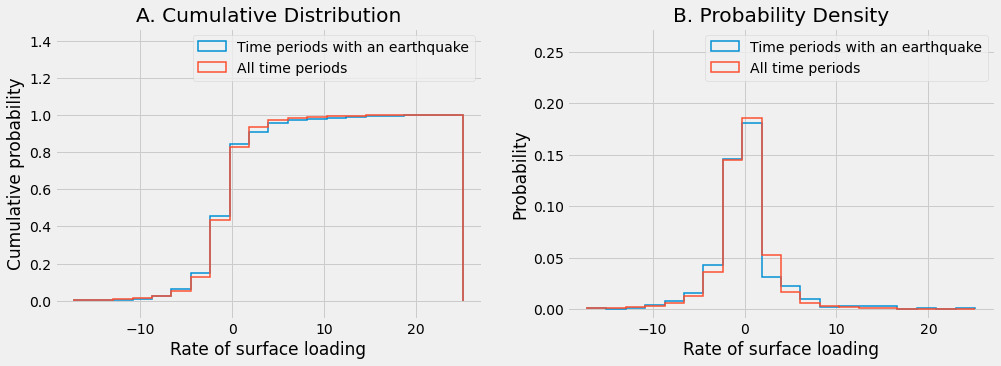

In [61]:
loadquakes.plot_hist_rate(ds['loading_rate'].data.flatten(), 
                          mainshock.loading_rate, ax1, ax2)

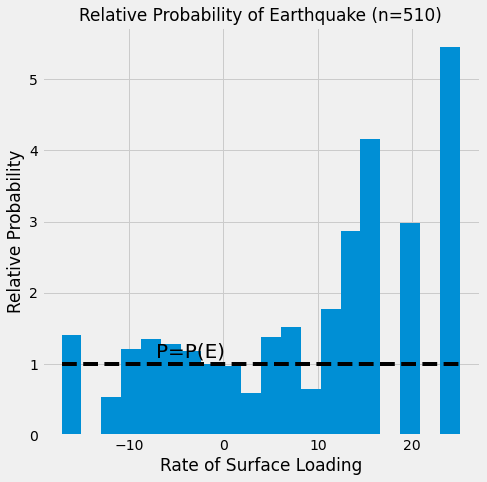

In [62]:
loadquakes.plot_rel_hist_rate(ds['loading_rate'].data.flatten(), 
                              mainshock.loading_rate, ax, 
                              'Relative Probability of Earthquake (n=510)')

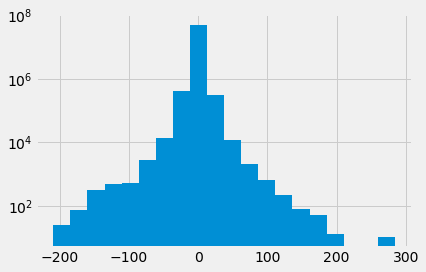

In [63]:
fig,ax=plt.subplots()
plt.hist(ds['loading_rate'].data.flatten(),20 )
plt.yscale('log')

In [65]:
conditional_probability_rate = loadquakes.get_cond_probability(
                                    np.array(ds['loading_rate'].data.flatten()),
                                    np.array(mainshock.loading_rate),
                                    np.array(mainshock.loading_rate))

mainshock['cp_rate'] = conditional_probability_rate

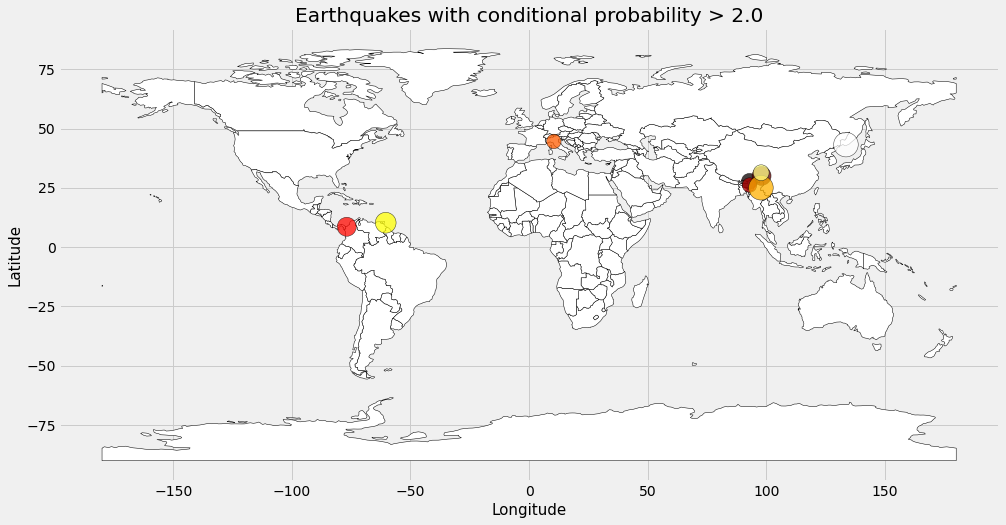

In [67]:
load_bounds = mainshock[mainshock['cp_rate']>2.0]

probability_map(load_bounds,load_bounds.cp_rate,
                'Earthquakes with conditional probability > 2.0')

In [ ]:
len(mainshock.loading_rate)